# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary
from utils.train_utils.model_utils import Conv2dBlock, UpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


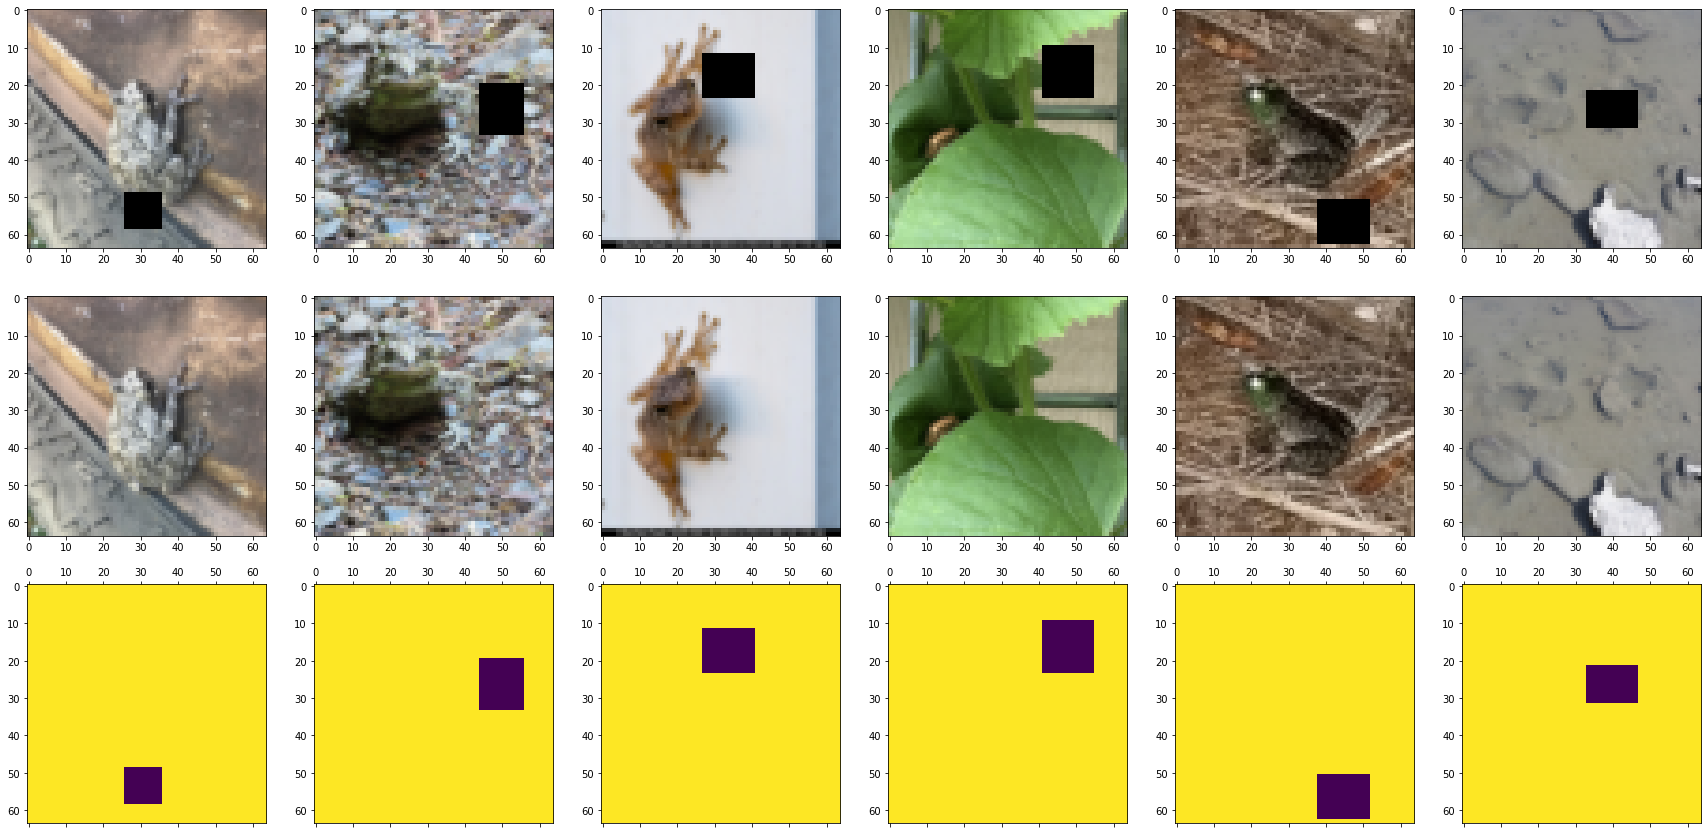

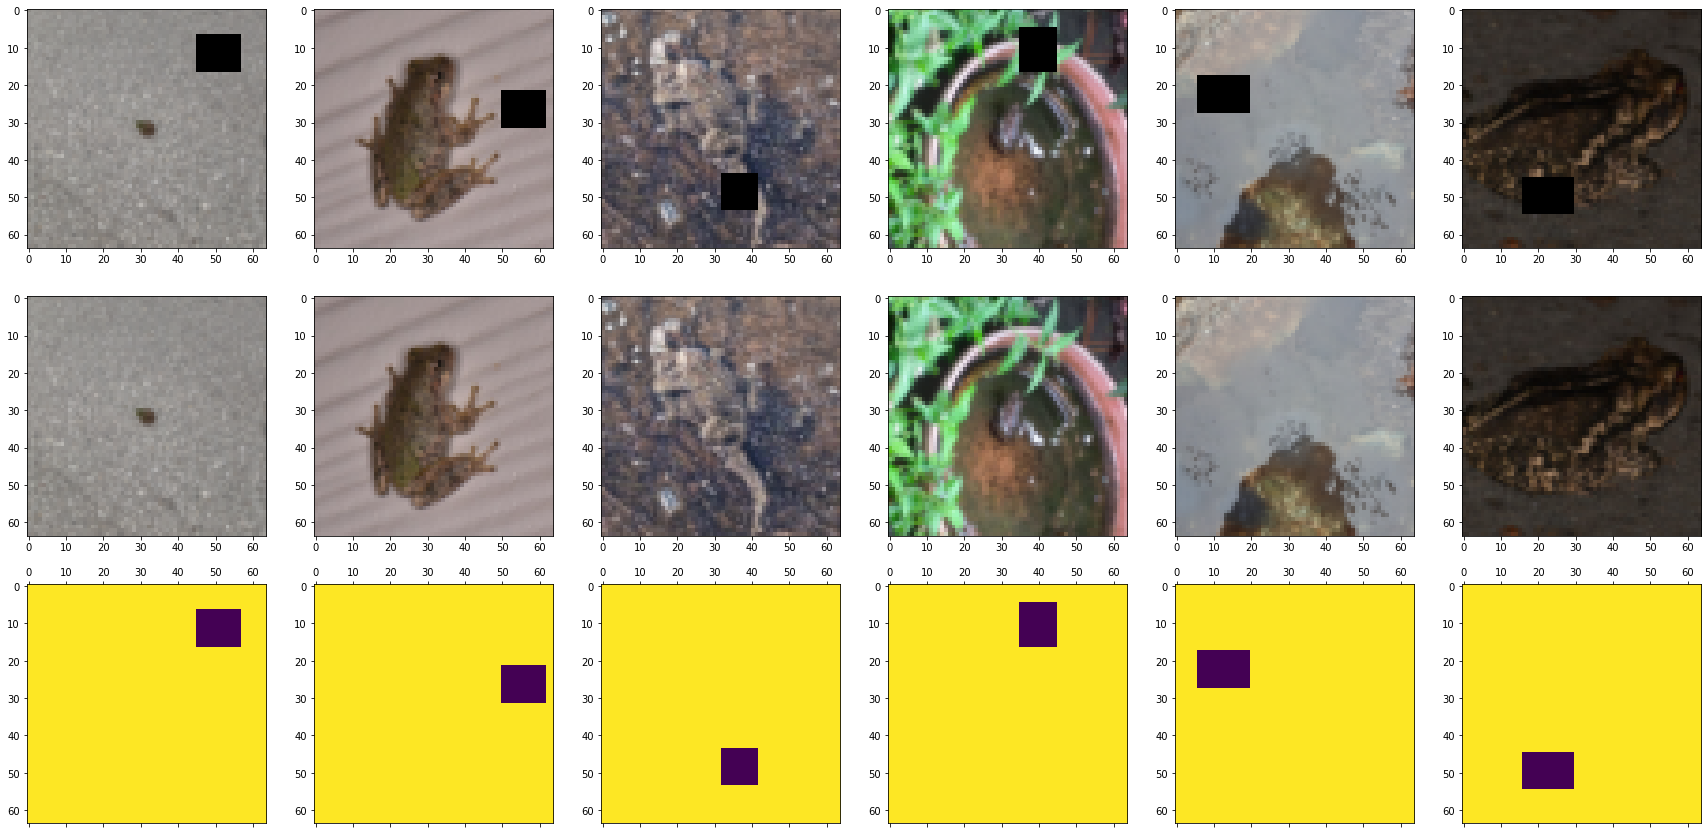

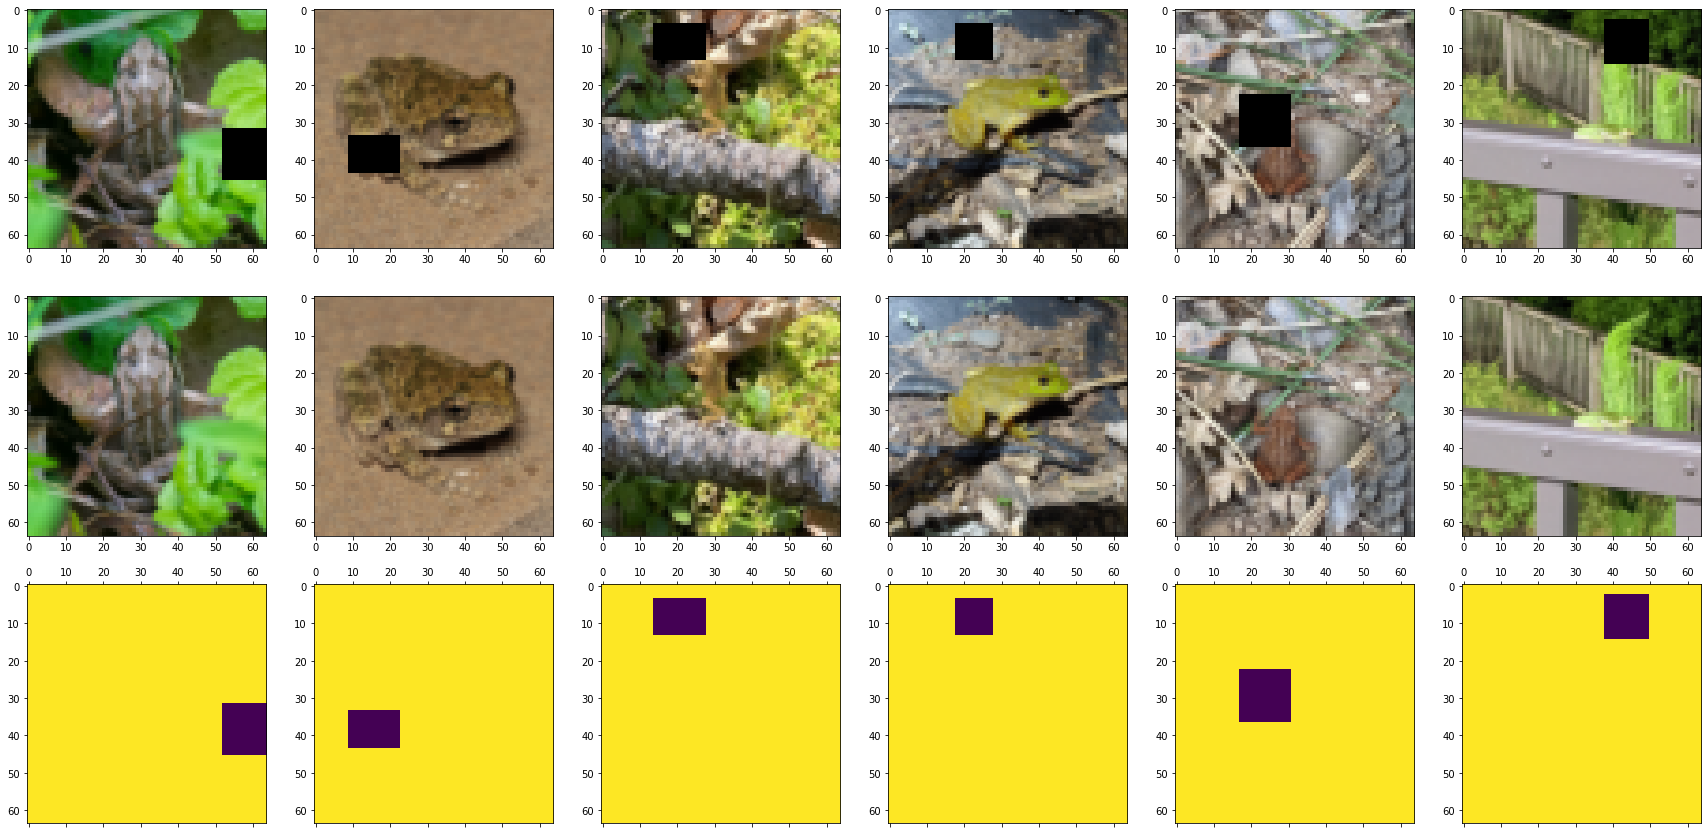

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore a basic GAN model.

# Model experiment


In [6]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> down -> same -> down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 8 x  same
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv6 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv7 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv8 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv9 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv10 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = UpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation, scale_factor = (2,2))
        self.conv13 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = UpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation, scale_factor = (2,2))
        self.conv15 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

    def forward(self, input_tensor):

        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x) + x
        x = self.conv5(x) + x
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x
        x = self.conv10(x) + x
        x = self.conv11(x) + x

        # up sample
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        return x


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x


# Training configuration

In [7]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model, but no dilated convolutions, and with residual skips. 
        """,
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/Vanilla/GAN/experiment_alpha0.01/generator/generator",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/Vanilla/GAN/experiment_alpha0.01/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 0.01,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [8]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], input_shape = 64, activation = MODEL_PARAMS["activation"])

summary(generator)
summary(discriminator)

# 2. device
parallel = True
device = 'cuda:3'  
devices = [3,1,2,0]

if not parallel:
    generator1 = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 0.560067 million parameters
model has 0.150401 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [9]:
wandb.init(project="Vanilla", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Train

## Train functions

In [10]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]

    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0
    running_results["loss_generator_r"] = 0.0
    running_results["loss_generator_adv"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()
            DISCRIMINATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output_batched = generator(input_batched)

            # 1.2 splice with ground truth
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            label_fake = torch.zeros(BATCH_SIZE, 1).to(device)

            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)

            pred_fake = discriminator(spliced_batched)
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator (reconstruction, adverserial)
            # 2.1 forward pass by generator to produce images, splice them
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_real) # want it to classify all as real

            # 2.5 backprop
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()
            running_results["loss_generator_adv"] += loss_g_adverserial.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [11]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # get shuffled indices
            shuffled_indices = torch.randperm(n = BATCH_SIZE).long()

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [12]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator"] = []
    train_results["loss_generator_r"] = []
    train_results["loss_generator_adv"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [13]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 29.69114736741589   L2 loss (Whole): 0.0014565395852250437   L2 loss (Mask): 0.125673922127293   L1 loss (Whole): 0.005017523763460979   L1 loss (Mask): 0.4339399182027386   LPIPS (Whole): 0.05076483319843969   loss_discriminator: 0.013975200729985392   loss_generator: 0.13263970243353998   loss_generator_r: 0.125673922127293   loss_generator_adv: 0.6965781208007567   197   
15/15: Peak SnR (Whole): 31.62036043802897   L2 loss (Whole): 0.0006881258178812762   L2 loss (Mask): 0.05993892500797907   L1 loss (Whole): 0.003727482414493958   L1 loss (Mask): 0.3247400681177775   LPIPS (Whole): 0.0364092859129111       
Completed epoch 1! Took 3.1767192204793293 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 31.693133175757623   L2 loss (Whole): 0.0006801715237088502   L2 loss (Mask): 0.05893696765265157   L1 loss (Whole): 0.0036984163606839796   L1 loss (Mask): 0.32051188157450766   LPIPS (Whole): 0.03559389738065581   los

({'Peak SnR (Whole)': [29.704417461004013,
   31.700739078032665,
   32.219998799837555,
   32.491629038101586,
   32.690120036785416,
   32.92098546639467,
   32.95474098890256,
   33.09788055908986,
   33.18545306034577,
   33.3873044527494,
   33.296093329405174,
   33.4023417692918,
   33.463645274822525,
   33.48965334280943,
   33.44145768728011,
   33.46689478556315,
   33.557679396409256,
   33.48684129959498,
   33.578640363155266,
   33.53010742480938],
  'L2 loss (Whole)': [0.001451475932322538,
   0.0006791144592287496,
   0.0006029410261619025,
   0.0005651987437606574,
   0.0005410508833264407,
   0.0005119026163578009,
   0.000508270094892046,
   0.000491115798537906,
   0.00048176077651964407,
   0.0004590026486160544,
   0.0004700613721163394,
   0.00045798706522850226,
   0.0004513273140615545,
   0.0004490284099562977,
   0.0004543684951316279,
   0.00045151500261197676,
   0.000442149948354106,
   0.00044946157271251414,
   0.00043982940890903893,
   0.0004450207585

In [14]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 33.55061635663432   L2 loss (Whole): 0.00044266347916075777   L2 loss (Mask): 0.03851621491053412   L1 loss (Whole): 0.002819244234612392   L1 loss (Mask): 0.24533347285562945   LPIPS (Whole): 0.026497530720887646   loss_discriminator: 0.009073105343287029   loss_generator: 0.0508588545024395   loss_generator_r: 0.03851621491053412   loss_generator_adv: 1.2342639692368047       
15/15: Peak SnR (Whole): 33.58126602172852   L2 loss (Whole): 0.0004457227400659273   L2 loss (Mask): 0.03900565678874652   L1 loss (Whole): 0.002794101694598794   L1 loss (Mask): 0.2447663595279058   LPIPS (Whole): 0.02577940473953883       
Completed epoch 21! Took 4.191826220353445 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 33.57538402926537   L2 loss (Whole): 0.0004398093046244955   L2 loss (Mask): 0.03815157522837962   L1 loss (Whole): 0.0028044479884087076   L1 loss (Mask): 0.24332072254150144   LPIPS (Whole): 0.02624268984842685

wandb: Network error (ReadTimeout), entering retry loop.


155/156: Peak SnR (Whole): 33.520711517333986   L2 loss (Whole): 0.0004459318244874838   L2 loss (Mask): 0.03855439888373498   L1 loss (Whole): 0.0028285574423329483   L1 loss (Mask): 0.24455609984936252   LPIPS (Whole): 0.025928655615256677   loss_discriminator: 0.00912363154573306   loss_generator: 0.05074684007033225   loss_generator_r: 0.03855439888373498   loss_generator_adv: 1.219244159037067        
15/15: Peak SnR (Whole): 33.44784164428711   L2 loss (Whole): 0.00045449560857377944   L2 loss (Mask): 0.039563317348559696   L1 loss (Whole): 0.0028306142427027225   L1 loss (Mask): 0.2464192748069763   LPIPS (Whole): 0.025929338360826174   
Completed epoch 28! Took 4.660071158409119 min
Saved models!

===== Epoch: 29 ===== 
155/156: Peak SnR (Whole): 33.470668669669855   L2 loss (Whole): 0.0004506038083139086   L2 loss (Mask): 0.039022567820164465   L1 loss (Whole): 0.0028480216184811244   L1 loss (Mask): 0.24664657164004541   LPIPS (Whole): 0.02605227439874603   loss_discriminator

({'Peak SnR (Whole)': [33.54705954820682,
   33.56985273116674,
   33.509857495625816,
   33.57355834276248,
   33.551982463934486,
   33.562978646694084,
   33.51206791706574,
   33.525038450192184,
   33.47014639927791,
   33.52029174413436,
   33.55058695719792,
   33.62655473366762,
   33.549606127616684,
   33.552126126411636,
   33.60275730719933,
   33.53290839072986,
   33.555606450790016,
   33.52754783630371,
   33.50121718186598,
   33.4965518560165],
  'L2 loss (Whole)': [0.0004430165979264973,
   0.00044041550557803695,
   0.00044682433844382805,
   0.0004402475831925702,
   0.0004423984381644867,
   0.0004418210192876032,
   0.0004460992189333177,
   0.00044549370851690095,
   0.00045065267402559327,
   0.00044577904564227,
   0.0004425849196521971,
   0.0004350199964485513,
   0.0004421792850152064,
   0.0004425925978396733,
   0.00043687312968242436,
   0.0004441330434369425,
   0.00044208614081771183,
   0.00044455479954381305,
   0.00044751242444946023,
   0.000447467

In [15]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)